## **Dushyant Homework Session 3**

# Homework 3:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing

And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?
For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [1]:
import torch, torchvision

In [2]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=4)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

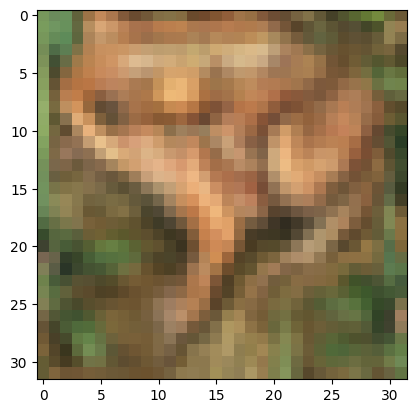

In [4]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

In [5]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [6]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[5,5],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Three more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )
#        self.conv4 = nn.Conv2d(in_channels=4*in_channels,
#                                     out_channels=in_channels,
#                                     kernel_size=1
#                                     )
        self.dropout = nn.Dropout(p=0.5) # Added a dropout with 50% probability


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        x = self.conv3(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        #x = self.conv4(x)
        
        x = self.dropout(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.ReLU(), #Specify Activation Function
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x

        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [7]:
model = Classifier(64, 3, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 256, 8, 8]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         1,664
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    │    └─Dropout: 3-5                 [128, 64, 32, 32]         --
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         1,664
│    │    └─LayerNorm: 3-7               [128, 64, 32, 32]  

In [8]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()

In [10]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [14]:
from tqdm.notebook import tqdm

epochs = 40
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        train_loss.append(loss)
        train_accuracy.append(acc)
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        val_loss.append(loss_val)
        val_accuracy.append(acc_val)


Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 0.472, accuracy: 83.714


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 0.604, accuracy: 79.302


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 0.447, accuracy: 84.627


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 0.595, accuracy: 80.103


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 0.451, accuracy: 84.095


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 0.596, accuracy: 79.846


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 0.414, accuracy: 85.441


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.535, accuracy: 81.102


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.426, accuracy: 85.091


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.544, accuracy: 81.062


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.421, accuracy: 85.256


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.562, accuracy: 81.339


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.438, accuracy: 84.974


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.556, accuracy: 80.795


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.434, accuracy: 84.794


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.588, accuracy: 79.826


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.408, accuracy: 85.947


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.537, accuracy: 81.448


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.395, accuracy: 86.297


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.530, accuracy: 81.596


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.386, accuracy: 86.754


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.537, accuracy: 82.180


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.400, accuracy: 86.317


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.549, accuracy: 81.715


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.394, accuracy: 86.272


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.550, accuracy: 81.932


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.382, accuracy: 86.938


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.543, accuracy: 81.379


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.369, accuracy: 87.086


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.526, accuracy: 81.922


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.389, accuracy: 86.591


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.550, accuracy: 81.507


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.399, accuracy: 86.085


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.556, accuracy: 81.537


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.369, accuracy: 87.158


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.521, accuracy: 82.308


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.362, accuracy: 87.502


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.530, accuracy: 81.853


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.385, accuracy: 86.674


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.541, accuracy: 82.061


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.377, accuracy: 86.986


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.552, accuracy: 81.655


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.385, accuracy: 86.771


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.564, accuracy: 81.942


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.361, accuracy: 87.545


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.547, accuracy: 82.170


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.346, accuracy: 87.992


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.537, accuracy: 82.565


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.369, accuracy: 87.448


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.545, accuracy: 82.506


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.325, accuracy: 88.686


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.504, accuracy: 83.139


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.353, accuracy: 87.485


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.524, accuracy: 82.367


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.340, accuracy: 88.254


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.514, accuracy: 82.684


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.387, accuracy: 86.741


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.553, accuracy: 81.804


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.322, accuracy: 88.611


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.505, accuracy: 82.763


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 0.315, accuracy: 89.008


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 0.492, accuracy: 83.633


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31: training loss: 0.337, accuracy: 88.321


Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 0.512, accuracy: 82.812


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32: training loss: 0.327, accuracy: 88.501


Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 0.529, accuracy: 82.625


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33: training loss: 0.307, accuracy: 88.988


Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 0.483, accuracy: 83.238


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34: training loss: 0.357, accuracy: 87.797


Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 0.556, accuracy: 82.011


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 0.336, accuracy: 88.411


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 0.552, accuracy: 82.170


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36: training loss: 0.340, accuracy: 88.311


Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 0.528, accuracy: 82.743


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37: training loss: 0.306, accuracy: 89.534


Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 0.505, accuracy: 83.159


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38: training loss: 0.330, accuracy: 88.316


Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 0.530, accuracy: 82.288


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39: training loss: 0.305, accuracy: 89.312


Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 0.504, accuracy: 83.614


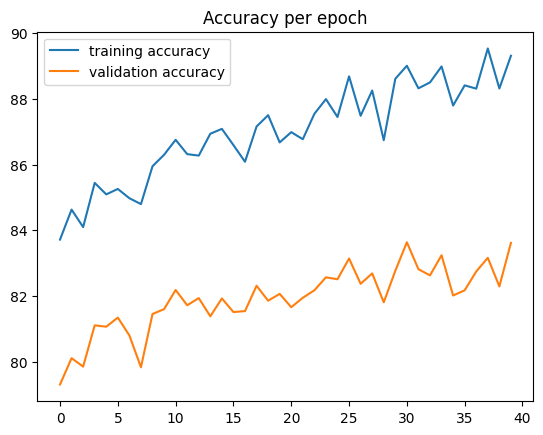

In [15]:
plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label= 'validation accuracy')
plt.title('Accuracy per epoch')
plt.legend();

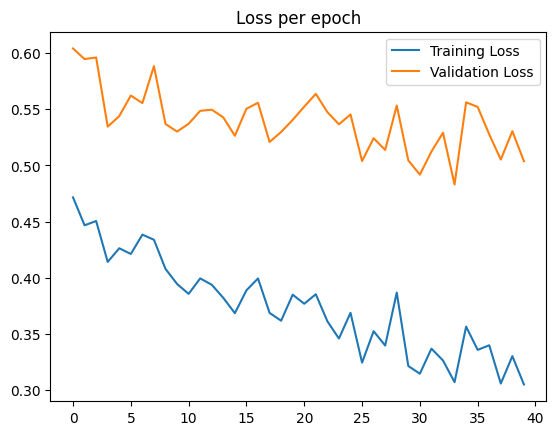

In [16]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label= 'Validation Loss')
plt.title('Loss per epoch')
plt.legend();

A slightly better validation accuracy of ~80%, than the provided model was achieved after iterating the model with the following parameters:
1. Added another layer (layer 4) of the nn.Conv2d.
2. Added few more dense layers.
3. Lowered the value of filter(kernel) size from 7 to 5 which allows us to capture smaller details from the images.

Initially, the model was overfitting(training accuracy > 90% and validation accuracy < 80%) so I then added DropOut layers between the dense layers as well as increased the value of weight_decay parameter to increase the effect of L2-Regularization.